In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

: 

In [2]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'data'
lr = 0.0005
epochs = 30
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
mixed_precision.set_global_policy('mixed_float16')

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26180 files belonging to 10 classes.
Using 20944 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26180 files belonging to 10 classes.
Using 5236 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


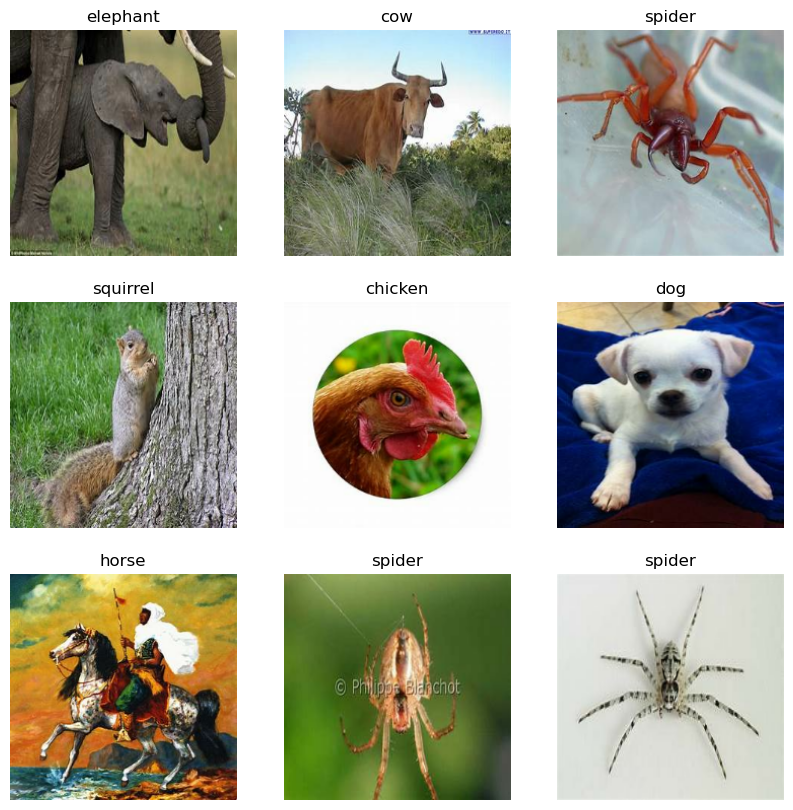

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

In [9]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [10]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [11]:
mobile_net_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
mobile_net_model.trainable = False

In [12]:
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    mobile_net_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer=Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=2)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 106s 147ms/step - accuracy: 0.5844 - loss: 1.3814 - val_accuracy: 0.9372 - val_loss: 0.2300 - learning_rate: 5.0000e-04
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 103s 144ms/step - accuracy: 0.8165 - loss: 0.5677 - val_accuracy: 0.9427 - val_loss: 0.2016 - learning_rate: 5.0000e-04
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 100s 141ms/step - accuracy: 0.8284 - loss: 0.5243 - val_accuracy: 0.9425 - val_loss: 0.1997 - learning_rate: 5.0000e-04
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 99s 140ms/step - accuracy: 0.8391 - loss: 0.4777 - val_accuracy: 0.9456 - val_loss: 0.1926 - learning_rate: 5.0000e-04
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 98s 141ms/step - accuracy: 0.8501 - loss: 0.4546 - val_accuracy: 0.9481 - val_loss: 0.1859 - learning_rate: 5.0000e-04
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 113s 163ms/step - accuracy: 0.8500 - loss: 0.4615 - val_accuracy: 0.9460 - val_loss: 0.1844 - learning_rate: 5.0000e-04
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 97

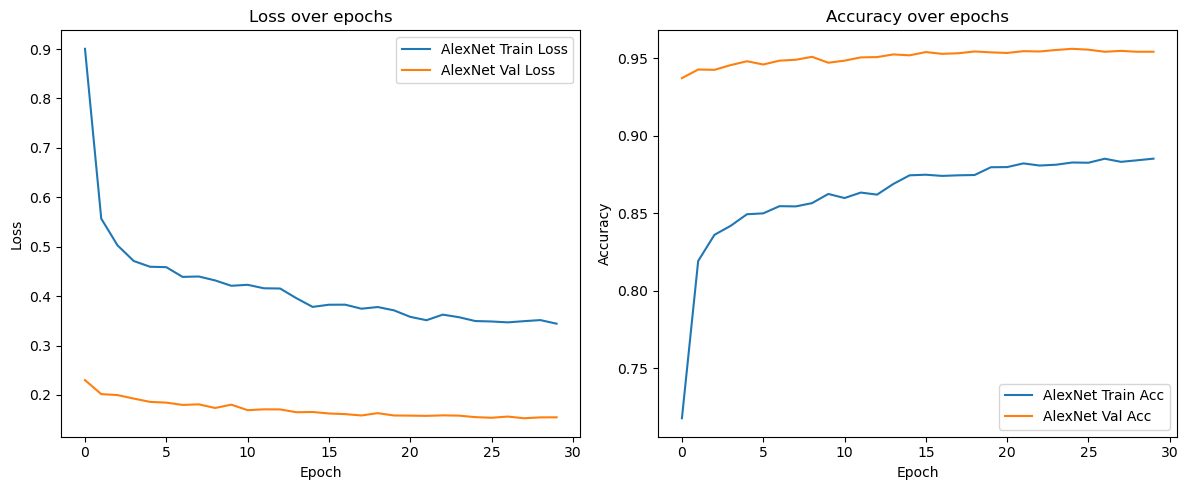

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='AlexNet Train Loss')
plt.plot(history.history['val_loss'], label='AlexNet Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='AlexNet Train Acc')
plt.plot(history.history['val_accuracy'], label='AlexNet Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


